In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob
import os
import scvi
import pickle
from scipy import sparse
import anndata as ad
import itertools

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("whitegrid")

from matplotlib.ticker import StrMethodFormatter
# ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

import requests
from tqdm import tqdm

from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde

In [ ]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 4000
)

sc.pp.normalize_total(adata)

sc.pp.log1p(adata)

# read in cell cycle genes and calculate cell cycle score
with open("cell_cycle_genes.pkl", "wb") as file:
    cell_cycle_genes = file

sc.tl.score_genes_cell_cycle(adata, s_genes = cell_cycle_genes["s_genes"], g2m_genes = cell_cycle_genes["g2m_genes"], use_raw = False)

In [2]:
adata = sc.read_h5ad("combined_counts_new_pp_seurat_v3.h5ad")

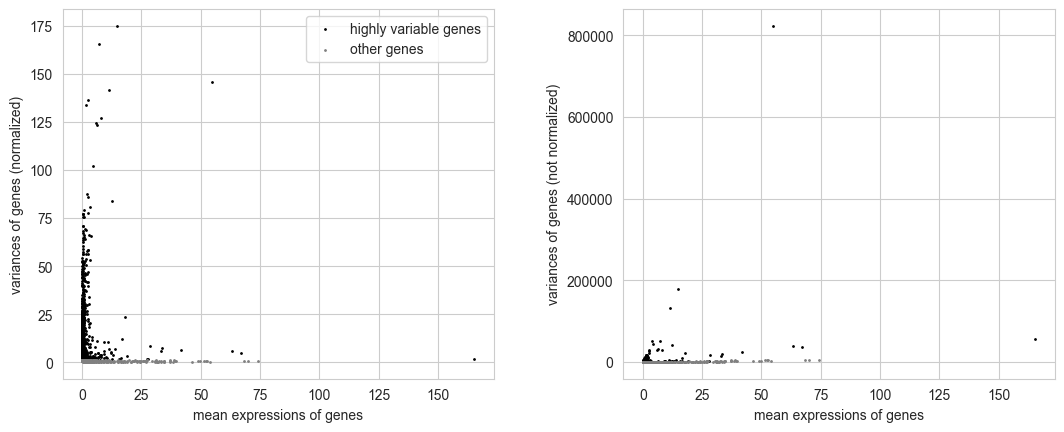

In [7]:
sc.pl.highly_variable_genes(adata)

In [10]:
# subset adata.var for 4k highly variable
adata = adata[:,adata.var["highly_variable"]]

In [22]:
# get rid of top 1%
adata = adata[:,adata.var["variances_norm"].sort_values(ascending = False)[int(adata.n_vars * 0.01):].index]

In [30]:
# regress out cell cycle and mito, ribo
sc.pp.regress_out(adata, ["S_score", "G2M_score", "pct_counts_mt", "pct_counts_ribo"])

In [31]:
sc.pp.scale(adata)

sc.pp.pca(adata)

In [42]:
import scanpy as sc
import scvi
from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde

In [ ]:
# add back in raw counts
adata_raw = sc.read_h5ad("C:/Users/randymi/Desktop/hs_omics_data/label transfer/New Data 2/combined_counts.h5ad")
adata.layers["counts"] = adata_raw[:,adata.var["gene-id"]].X

In [8]:
scvi.model.SCVI.setup_anndata(adata, batch_key="GSM", layer = "counts")


In [9]:
vae_default = scvi.model.SCVI(adata)

In [10]:
vae_default.to_device('cuda:0')

In [11]:
vae_default.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\randymi\anaconda3\envs\scanpy\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 36/36: 100%|██████████| 36/36 [08:39<00:00, 14.88s/it, v_num=1, train_loss_step=529, train_loss_epoch=629]

`Trainer.fit` stopped: `max_epochs=36` reached.


Epoch 36/36: 100%|██████████| 36/36 [08:39<00:00, 14.42s/it, v_num=1, train_loss_step=529, train_loss_epoch=629]


In [12]:
adata.obsm["X_scVI_default"] = vae_default.get_latent_representation()

In [13]:
sc.pp.neighbors(adata, use_rep="X_scVI_default")
sc.tl.leiden(adata)

C:\Users\randymi\AppData\Local\Temp\ipykernel_13932\1785277102.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


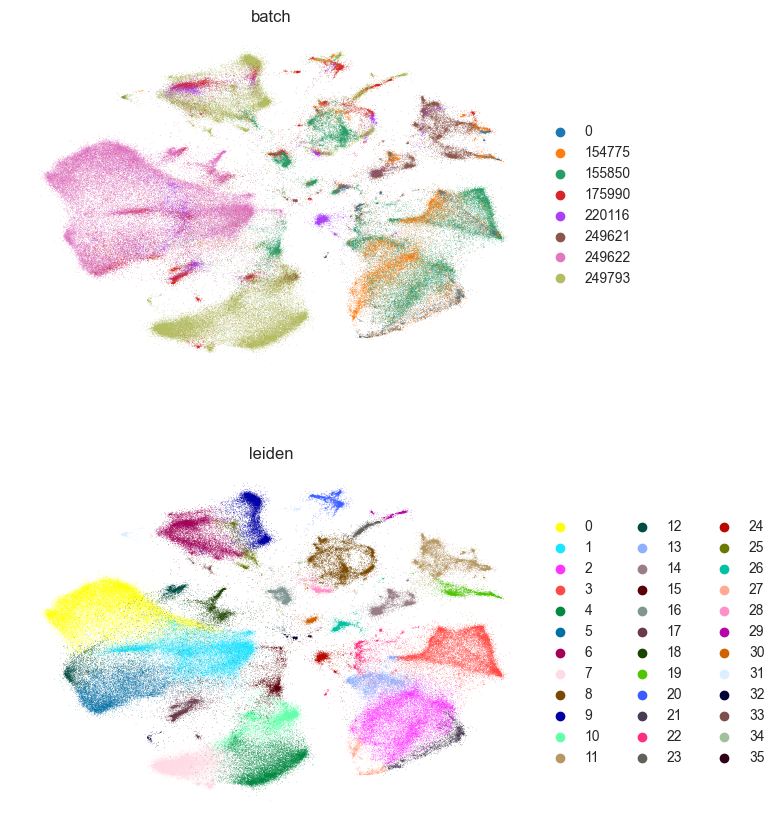

In [17]:
# pymde is gpu alternativ to ump
adata.obsm["X_mde"] = mde(adata.obsm["X_scVI_default"])

# same as sc.pl.umap, except you can choose the basis (umap, pca)
sc.pl.embedding(
    adata,
    basis="X_mde",
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

In [20]:
# compare with harmony
sc.external.pp.harmony_integrate(adata, key = "GSM", basis = 'X_pca')


2024-08-28 08:51:55,168 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
c:\Users\randymi\anaconda3\envs\scanpy\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2024-08-28 08:52:11,569 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-28 08:52:12,584 - harmonypy - INFO - Iteration 1 of 10
2024-08-28 08:53:45,204 - harmonypy - INFO - Iteration 2 of 10
2024-08-28 08:55:17,152 - harmonypy - INFO - Iteration 3 of 10
2024-08-28 08:56:49,581 - harmonypy - INFO - Iteration 4 of 10
2024-08-28 08:58:22,399 

In [21]:
adata.obsm

AxisArrays with keys: X_pca, X_scVI_default, X_mde, X_pca_harmony

In [22]:
adata.obsm["X_mde_harmony"] = mde(adata.obsm["X_pca_harmony"])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


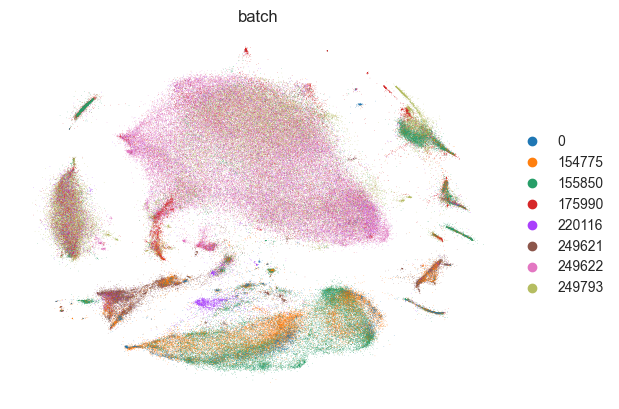

In [23]:
sc.pl.embedding(
    adata,
    basis="X_mde_harmony",
    color=["batch"],
    frameon=False,
    ncols=1,
)

In [24]:
adata.write_h5ad("counts_pp_new_neighbors.h5ad")